In [1]:
import os 
import math
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
import seaborn as sn
%matplotlib inline

data_folder = '../data/'

# Data Description
Plot the data points location distribution

In [2]:
columns = ['RELI', 'EAST', 'NORTH']

trainset_data = pd.read_csv(os.path.join(data_folder, 'trainset_with_neighbour.csv'), usecols=columns)
trainset_data.set_index('RELI', inplace=True)
trainset_data.head()

,EAST,NORTH
RELI,,
48561099,2485600,1109900
48611112,2486100,1111200
48621113,2486200,1111300
48621114,2486200,1111400
48621115,2486200,1111500


<AxesSubplot:xlabel='EAST', ylabel='NORTH'>

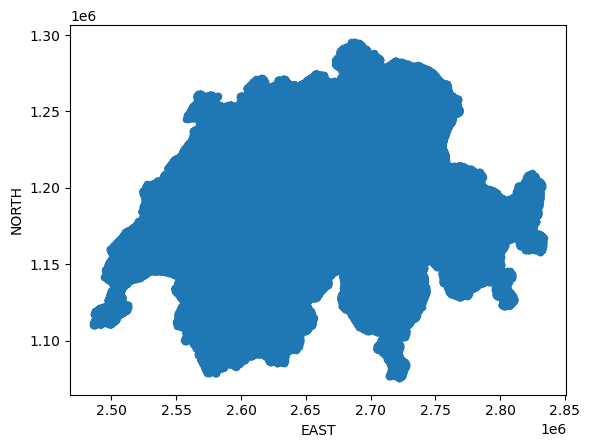

In [3]:
trainset_data.plot(x='EAST', y='NORTH', kind='scatter')

### Neighbor count matrix for Land Usage

<img src='../img/Land_Uasge_matrix.png'>

# Logistic Regression

### A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 
- Standardize the values of each feature in the data to have mean 0 and variance 1.

In [4]:
columns = ['LU4', 'LC4', 'LU3', 'LC3', 'LU2', 'LC2', 'LU1', 'LC1', 'nbr1_LU3', 'nbr1_LC3', 'nbr1_LU2', 'nbr1_LC2', 'nbr1_LU1',
           'nbr1_LC1', 'nbr2_LU3', 'nbr2_LC3', 'nbr2_LU2', 'nbr2_LC2', 'nbr2_LU1', 'nbr2_LC1', 'nbr3_LU3', 'nbr3_LC3',
           'nbr3_LU2', 'nbr3_LC2', 'nbr3_LU1', 'nbr3_LC1', 'nbr4_LU3', 'nbr4_LC3', 'nbr4_LU2', 'nbr4_LC2', 'nbr4_LU1',
           'nbr4_LC1', 'nbr5_LU3', 'nbr5_LC3', 'nbr5_LU2', 'nbr5_LC2', 'nbr5_LU1', 'nbr5_LC1', 'nbr6_LU3', 'nbr6_LC3',
           'nbr6_LU2', 'nbr6_LC2', 'nbr6_LU1', 'nbr6_LC1', 'nbr7_LU3', 'nbr7_LC3', 'nbr7_LU2', 'nbr7_LC2', 'nbr7_LU1',
           'nbr7_LC1', 'nbr8_LU3', 'nbr8_LC3', 'nbr8_LU2', 'nbr8_LC2', 'nbr8_LU1', 'nbr8_LC1']

original_data = pd.read_csv(os.path.join(data_folder, 'trainset_with_neighbour.csv'), index_col=0)
original_data = original_data[columns]
original_data.head()

,LU4,LC4,LU3,LC3,LU2,LC2,LU1,LC1,nbr1_LU3,nbr1_LC3,...,nbr7_LU2,nbr7_LC2,nbr7_LU1,nbr7_LC1,nbr8_LU3,nbr8_LC3,nbr8_LU2,nbr8_LC2,nbr8_LU1,nbr8_LC1
RELI,,,,,,,,,,,,,,,,,,,,,
48561099,LU301,LC41,LU301,LC41,LU301,LC41,LU301,LC41,LU301,LC41,...,LU221,LC21,LU221,LC21,LU301,LC41,LU301,LC41,LU301,LC41
48611112,LU402,LC61,LU402,LC61,LU402,LC61,LU402,LC61,LU402,LC61,...,LU221,LC21,LU221,LC21,LU221,LC21,LU221,LC21,LU221,LC21
48621113,LU103,LC47,LU103,LC47,LU421,LC31,LU421,LC31,LU106,LC12,...,LU222,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61
48621114,LU106,LC12,LU106,LC12,LU106,LC12,LU106,LC12,LU142,LC15,...,LU222,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61
48621115,LU142,LC11,LU142,LC15,LU142,LC15,LU142,LC15,LU402,LC61,...,LU222,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61


In [5]:
print('The length of the data with all rows is : {}'.format(len(original_data)))
original_data.dropna(inplace=True)
print('The length of the data without the rows with nan value is: {}'.format(len(original_data)))

The length of the data with all rows is : 348474
The length of the data without the rows with nan value is: 348474


In [6]:
data_features = original_data.copy()
data_features['changed'] = [0 if row['LU4'] == row['LU3'] and row['LC4'] == row['LC3'] else 1 for ind, row in data_features[['LU4', 'LC4', 'LU3', 'LC3']].iterrows()]
data_features.head()

,LU4,LC4,LU3,LC3,LU2,LC2,LU1,LC1,nbr1_LU3,nbr1_LC3,...,nbr7_LC2,nbr7_LU1,nbr7_LC1,nbr8_LU3,nbr8_LC3,nbr8_LU2,nbr8_LC2,nbr8_LU1,nbr8_LC1,changed
RELI,,,,,,,,,,,,,,,,,,,,,
48561099,LU301,LC41,LU301,LC41,LU301,LC41,LU301,LC41,LU301,LC41,...,LC21,LU221,LC21,LU301,LC41,LU301,LC41,LU301,LC41,0
48611112,LU402,LC61,LU402,LC61,LU402,LC61,LU402,LC61,LU402,LC61,...,LC21,LU221,LC21,LU221,LC21,LU221,LC21,LU221,LC21,0
48621113,LU103,LC47,LU103,LC47,LU421,LC31,LU421,LC31,LU106,LC12,...,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61,0
48621114,LU106,LC12,LU106,LC12,LU106,LC12,LU106,LC12,LU142,LC15,...,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61,0
48621115,LU142,LC11,LU142,LC15,LU142,LC15,LU142,LC15,LU402,LC61,...,LC21,LU222,LC21,LU402,LC61,LU402,LC61,LU402,LC61,1


In [7]:
print('Total number of tiles that changed label in either Land Cover or Land Usage: %d' % sum(data_features.changed))

Total number of tiles that changed label in either Land Cover or Land Usage: 58737


In [8]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [9]:
[train, test] = split_set(data_features)

In [10]:
train_categorical = pd.get_dummies(train)
train_categorical.columns

Index(['changed', 'LU4_LU101', 'LU4_LU102', 'LU4_LU103', 'LU4_LU104',
       'LU4_LU105', 'LU4_LU106', 'LU4_LU107', 'LU4_LU108', 'LU4_LU121',
       ...
       'nbr8_LC1_LC45', 'nbr8_LC1_LC46', 'nbr8_LC1_LC47', 'nbr8_LC1_LC51',
       'nbr8_LC1_LC52', 'nbr8_LC1_LC53', 'nbr8_LC1_LC61', 'nbr8_LC1_LC62',
       'nbr8_LC1_LC63', 'nbr8_LC1_LC64'],
      dtype='object', length=2045)

In [11]:
# Make sure we use only the features available in the training set
test_categorical = pd.get_dummies(test)[train_categorical.columns]

In [12]:
train_label=train_categorical.changed
train_features = train_categorical.drop('changed', axis=1)
print('Length of the train dataset : {}'.format(len(train)))

test_label=test_categorical.changed
test_features = test_categorical.drop('changed', axis=1)
print('Length of the test dataset : {}'.format(len(test)))

Length of the train dataset : 278573
Length of the test dataset : 69901


### B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities.
- For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class.

In [13]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5, definition='normal'): 
    
    assert definition == 'normal' or definition == 'special'
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
    
    if definition == 'normal':
        # normal definition of confusion matrix 
        TP = np.sum(np.logical_and(predict_label==1, true_label==1))
        TN = np.sum(np.logical_and(predict_label==0, true_label==0))
        FP = np.sum(np.logical_and(predict_label==1, true_label==0))
        FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    elif definition == 'special':
        # special definition of the confusion matrix in this case to optimize the recall and precision of unchanged
        TP = np.sum(np.logical_and(predict_label==0, true_label==0))
        TN = np.sum(np.logical_and(predict_label==1, true_label==1))
        FP = np.sum(np.logical_and(predict_label==0, true_label==1))
        FN = np.sum(np.logical_and(predict_label==1, true_label==0))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix, thred, axs):
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 
    
    sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='',ax=axs)
    axs.set_xlabel('Actual')
    axs.set_ylabel('Predicted')
    axs.set_title('Confusion matrix for a {} threshold'.format(thred))
    


def compute_all_score(confusion_matrix, t=0.5):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [16]:
# Load from file
pkl_filename = "../models/logistic_regression.pkl"
with open(pkl_filename, 'rb') as file:
    logistic = pickle.load(file)

In [ ]:
logistic = LogisticRegression(solver='sag', max_iter=1000, class_weight='balanced', verbose=1, warm_start=True, n_jobs=-1, multi_class='ovr')
logistic.fit(train_features,train_label)

In [17]:
prediction_proba = logistic.predict_proba(test_features)

In [ ]:
# Save to file in the current working directory
pkl_filename = "../models/logistic_regression.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(logistic, file)

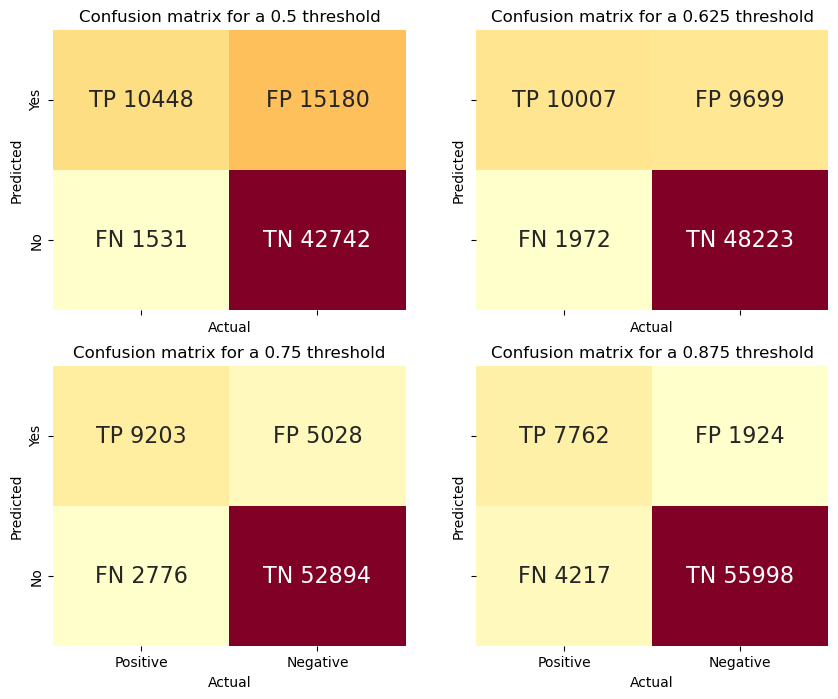

In [18]:
confusion_matrix_ls = []
thred_ls = [0.5, 0.625, 0.75, 0.875]

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,8))

for axe, thred in zip(axs.flat, thred_ls):
    confusion_matrix = compute_confusion_matrix(test_label, prediction_proba, thred, definition='normal')
    confusion_matrix_ls.append(confusion_matrix)
    plot_confusion_matrix(confusion_matrix, thred, axe)
    

In [19]:
for confusion_matrix, thred in zip(confusion_matrix_ls, thred_ls):
    [t, accuracy, precision_positive, recall_positive, F1_score_positive, \
        precision_negative, recall_negative, F1_score_negative] = compute_all_score(confusion_matrix)

    print("The accuracy of model with threshoud {0} is {1:1.3f}".format(thred, accuracy))
    print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
          .format(precision_positive, recall_positive, F1_score_positive))
    print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
          .format(precision_negative, recall_negative, F1_score_negative))
    print('========'*12)

The accuracy of model with threshoud 0.5 is 0.761
For the positive case, the precision is 0.408, the recall is 0.872 and the F1 score is 0.556
For the negative case, the precision is 0.965, the recall is 0.738 and the F1 score is 0.836
The accuracy of model with threshoud 0.625 is 0.833
For the positive case, the precision is 0.508, the recall is 0.835 and the F1 score is 0.632
For the negative case, the precision is 0.961, the recall is 0.833 and the F1 score is 0.892
The accuracy of model with threshoud 0.75 is 0.888
For the positive case, the precision is 0.647, the recall is 0.768 and the F1 score is 0.702
For the negative case, the precision is 0.950, the recall is 0.913 and the F1 score is 0.931
The accuracy of model with threshoud 0.875 is 0.912
For the positive case, the precision is 0.801, the recall is 0.648 and the F1 score is 0.717
For the negative case, the precision is 0.930, the recall is 0.967 and the F1 score is 0.948


In [20]:
# Save tuple
tuple_objects = (logistic, prediction_proba, train_features, train_label, test_features, test_label)
pickle.dump(tuple_objects, open("../models/logistic_tuple.pkl", 'wb'))

In [ ]:
# Restore tuple
# logistic, prediction_proba, train_features, train_label, 
# test_features, test_label = pickle.load(open("tuple_model.pkl", 'rb'))

### C) Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold.

In [21]:
threshold = np.linspace(0, 1, 100)
columns_score_name = ['Threshold', 'Accuracy', 'Precision P', 'Recall P', 'F1 score P', \
                                              'Precision N', 'Recall N', 'F1 score N']
threshold_score = pd.concat([pd.DataFrame([compute_all_score(compute_confusion_matrix(test_label, prediction_proba, t ),t)]\
                                             , columns=columns_score_name) for t in threshold], ignore_index=True)
threshold_score.set_index('Threshold', inplace=True)

Text(0.5, 1.0, 'Accuracy')

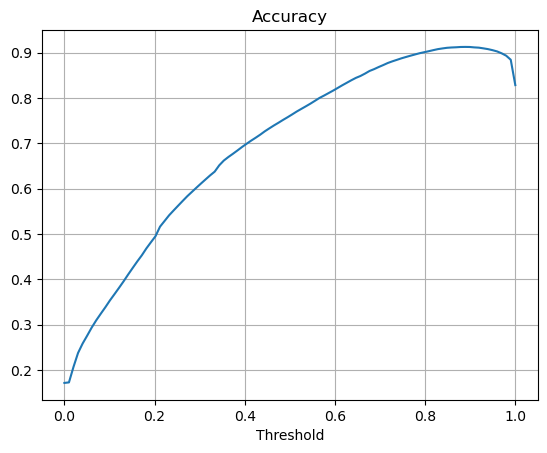

In [22]:
threshold_score['Accuracy'].plot(grid=True).set_title('Accuracy')

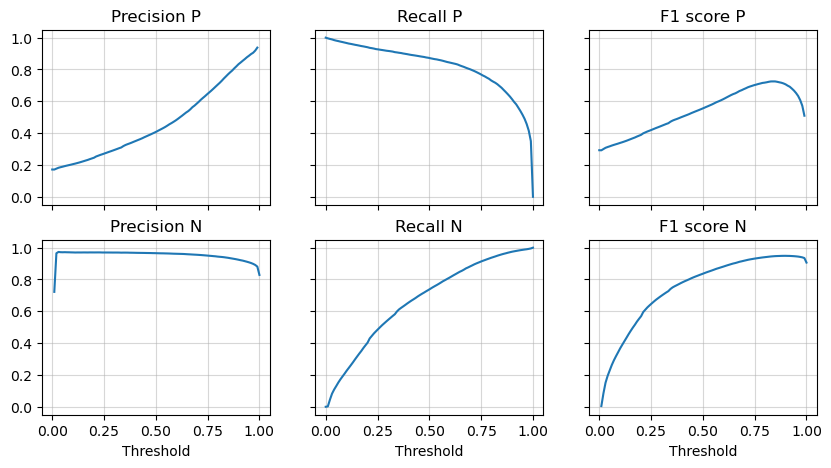

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10,5))

col_plot = ['Precision P', 'Recall P', 'F1 score P', 'Precision N', 'Recall N', 'F1 score N']

major_ticks = np.linspace(0,1,5)

for axe, col in zip(axs.flat, col_plot):
    threshold_score[col].plot(ax=axe, grid = True)
    axe.set_title(col)
    axe.set_xticks(major_ticks)    
    axe.grid(which='major', alpha=0.5)